# Проект «Рекомендация тарифов»

# Описание
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.
Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. 

## Откроем и изучим файл с данными.

In [118]:
#Уберем предупреждения
#D:\installed\anaconda3\envs\praktikum_env_win_new\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
#  if _joblib.__version__ >= LooseVersion('0.12'):

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
from joblib import dump

#классификация
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
%pip install seaborn==0.11.2

In [ ]:
try:
    df = pd.read_csv('users_behavior.csv')
except FileNotFoundError:
    df = pd.read_csv('users_behavior.csv')

In [122]:
display(df.head())
df.info()
df.describe()

#проверим как влияет удаление признака на accuracy 
#df = df.drop(['mb_used'], axis=1)

In [153]:
#рассчитаем корреляцию признаков
df.corr()

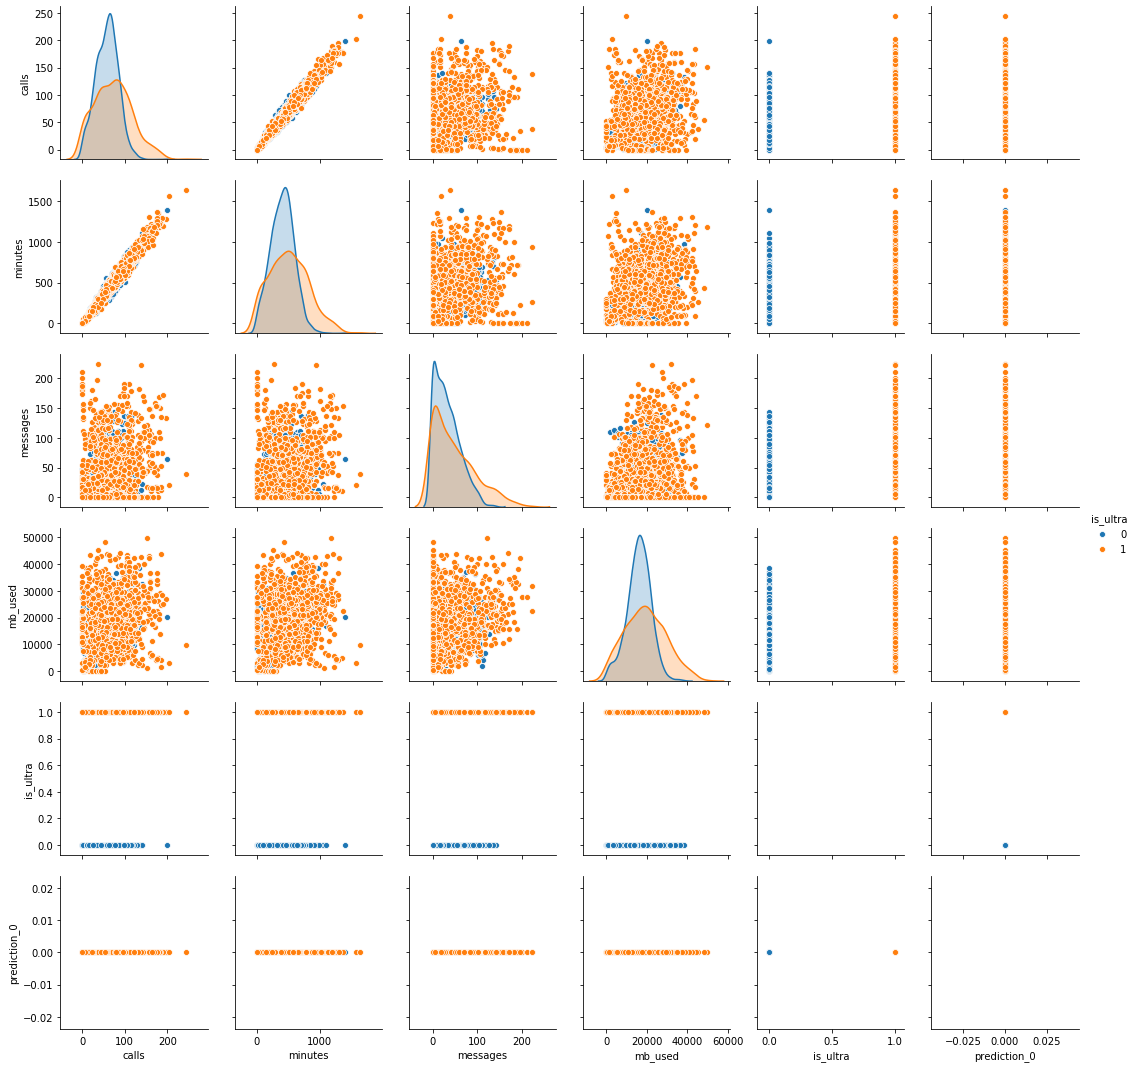

In [152]:
#оценим взаимосвязи в данных и влияние параметров на целевой признак
sns.pairplot(df, hue="is_ultra")

### Вывод
Пропусков данных нет, типы даннов корректные, заголовки в snake_case.

По шкале Чеддока -корреляция между целевым и остальными признаками -очень слабая (от 0,0 до 0,3)

## Разделим исходные данные на обучающую, валидационную и тестовую выборки.



In [123]:
features = df.drop(['is_ultra'], axis=1) # извлечем признаки 
target = df['is_ultra'] # извлечем целевой признак

# отделим выборки, 60% обучающая-train, валидационная 20%, тестовая 20%
# отделим 40% данных для валидационной и тестовой выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345) 
# разделим выборку пополам, получим валидационная 20%, тестовая 20% от исходной
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345) 

print('features', features.shape)
print('features_train', features_train.shape)
print('features_valid_test', features_valid_test.shape)
print('features_valid', features_valid.shape)
print('features_test', features_test.shape)

### Вывод
В доке на train_test_split нет деления на 3 выборки. Есть деление на 3 выборки через функцию -но выглядит громоздко и некрасиво, поэтому применили дважды последовательно train_test_split. 

## Исследуем качество разных моделей, меняя гиперпараметры. ***



 ###  Решающее дерево DecisionTreeClassifier

In [124]:
%%time

best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 100):
    
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучите модель с заданной глубиной дерева
    model.fit(features_train, target_train) # обучите модель
    
    #train_predictions = model.predict(features_train) # получите предсказания модели
    #result = accuracy_score(target_train, train_predictions)  # посчитайте качество модели
    result = model.score(features_train, target_train) #заменим 2 строки одной
    
    if result > best_result:
        best_model = model
        best_result = result
        #best_depth = depth
print("Accuracy лучшей модели на обучающей выборке: {0:.2f} %".format(100 * best_result)) 

# Save to file in the current working directory 
dump(best_model, 'model_decisiontreeclassifier.joblib')

### Случайный лес RandomForestClassifier

In [125]:
%%time

best_model = None
best_result = 0
for est in range(1, 100):
    
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    
    #train_predictions = model.predict(features_train) 
    # получите предсказания модели // не нужно тк model.score включает predictions?
    result = model.score(features_train, target_train)  # посчитайте качество модели 
    
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_result = result #  сохраните наилучшее значение метрики accuracy
        best_est = est

print("Accuracy лучшей модели на обучающей выборке: {0:.2f} %".format(100 * best_result)) 
print("Количество деревьев лучшей модели на обучающей выборке: {0:.0f}".format(best_est)) 

# Save to file in the current working directory 
dump(best_model, 'model_randomforestclassifier.joblib')

### Логистическая регрессия LogisticRegression 

In [126]:
%%time

model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train) 
#model.predict(features) 
#model.score(features, target) 

result = model.score(features_train, target_train)
print("Train score: {0:.2f} %".format(100 * result)) 

# Save to file in the current working directory 
dump(model, 'model_logisticregression.joblib')

### Вывод
Применим сохранение моделей чтобы вызвать позже без повторной инициализации. Случайный лес RandomForestClassifier выдает высшее качество на обучающей модели а Логистическая регрессия LogisticRegression - самое низкое.

## Проверим качество модели на валидационной выборке, меняя гиперпараметры. 

### Найдем лучшие праметры с помощью GridSearchCV

In [127]:
%%time

#время подбора параметров GridSearchCV на локальном компьютере -около 5,5 минут
#время с привлечением всех ядер процессора параметром n_jobs = -1, обучение завершилось за 1 минуту (при наличии 4х ядер)

#объявляем классификатор RandomForest, не внося в него никаких параметров
model = RandomForestClassifier()

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
#инструмент работает с диапазоном, а нам нужно фикс значение random_state, поэтому схитрим с диапазоном - (12345, 12346, 10)
parametrs = { 'random_state': range (12345, 12346, 10), 
              'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 13, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2) }

#запускаем обучение
#n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП
grid = GridSearchCV(model, parametrs, cv=5, n_jobs = -1)
grid.fit(features_train, target_train)

#выводим лучшием параметры
grid.best_params_

Лучшие параметры модели согласно подбору GridSearchCV

    {'max_depth': 9,
     'min_samples_leaf': 1,
     'min_samples_split': 6,
     'n_estimators': 30,
     'random_state': 12345}

### Инициализируем и проверим лучшую модель согласно п.3.2 с лучшими параметрами из п.4.1

In [128]:
# обучим модель на тренировочной выборке
model = RandomForestClassifier(random_state=12345, n_estimators=30, min_samples_split=6, min_samples_leaf=1, max_depth=9) 
model.fit(features_train, target_train) 

# посчитаем качество модели на обучающей и на валидационной выборке
result_train = model.score(features_train, target_train)
result_valid = model.score(features_valid, target_valid)

print("Accuracy на обучающей выборке: {0:.2f} %".format(100 * result_train)) 
print("Accuracy на валидационной выборке: {0:.2f} %".format(100 * result_valid)) 

# Save to file in the current working directory 
dump(best_model, 'model_randomforestclassifier_gridsearchcv.joblib')

### Найдем лучшие праметры с помощью RandomizedSearchCV

In [147]:
%%time

#объявляем классификатор RandomForest, не внося в него никаких параметров
model = RandomForestClassifier()

#создаем словарь, в который вписываем параметры, которые будем прогонять 
#инструмент работает с диапазоном, а нам нужно фикс значение random_state, поэтому схитрим с диапазоном - (12345, 12346, 10)
parametrs = { 'random_state': range (12345, 12346, 10), 
              'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2, 10, 2) }

#запускаем обучение
#n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП
grid = RandomizedSearchCV(model, parametrs, cv=5, n_jobs = -1, scoring = 'neg_log_loss', n_iter=300)
grid.fit(features_train, target_train)

#выводим лучшием параметры
grid.best_params_

    Лучшие параметры модели согласно подбору RandomizedSearchCV
    (меняются при каждом перезапуске оправдывая название)

    {'random_state': 12345,
    'n_estimators': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_depth': 11}

### Инициализируем и проверим лучшую модель согласно п.3.2 с лучшими параметрами из п.4.3

In [130]:
# обучим модель на тренировочной выборке
model = RandomForestClassifier(random_state=12345, n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_depth=11) 
model.fit(features_train, target_train) 

# посчитаем качество модели на обучающей и на валидационной выборке
result_train = model.score(features_train, target_train)
result_valid = model.score(features_valid, target_valid)

print("Accuracy на обучающей выборке: {0:.2f} %".format(100 * result_train)) 
print("Accuracy на валидационной выборке: {0:.2f} %".format(100 * result_valid)) 

# Save to file in the current working directory 
dump(best_model, 'model_randomforestclassifier_randomizedsearchcv.joblib')

### Вывод   
    Различие методов RandomizedSearchCV и GridSearchCV, также и в том что RandomizedSearchCV заменяет поиск параметров по сетке GridSearchCV на случайную выборку в пространстве параметров, благодаря чему скорость подбора параметров RandomizedSearchCV на порядок выше чем у GridSearchCV, при этом качество остается на уровне GridSearchCV.
    
    В данном частном случаем, Accuracy - показал выше подбор гиперпараметров (при одинаковом диапазоне гиперпараметров!) методом RandomizedSearchCV, что удивительно (и непонятно!) тк GridSearchCV перебирает и сравнивает все возможные сочетания гиперпараметров (сетку). 

## Проверим качество модели на тестовой выборке. 


### Решающее дерево DecisionTreeClassifier

In [131]:
# Load from file 
model = joblib.load('model_decisiontreeclassifier.joblib')
#model.fit(features, target) обучать не нужно тк загрузили обученную модель
#model.predict(features_test) 
#model.score(features_test, target_test)

result = model.score(features_test, target_test)
print("Test score: {0:.2f} %".format(100 * result)) 

### Случайный лес RandomForestClassifier

In [132]:
# Load from file 
model = joblib.load('model_randomforestclassifier.joblib')

result = model.score(features_test, target_test)
print("Test score: {0:.2f} %".format(100 * result)) 

### Логистическая регрессия LogisticRegression 

In [133]:
# Load from file 
model = joblib.load('model_logisticregression.joblib')

result = model.score(features_test, target_test)
print("Test score: {0:.2f} %".format(100 * result)) 

### Случайный лес RandomForestClassifier 
    -с параметрами подобранными GridSearchCV 
    -и обученная на увеличенной выборке train_valid

In [134]:
#объединим выборки для обучения
features_train_valid = pd.concat([features_train, features_valid], axis=0)
target_train_valid   = pd.concat([target_train, target_valid], axis=0)

print('features_train', features_train.shape)
print('features_valid', features_valid.shape)
print('features_train_valid', features_train_valid.shape)

In [135]:
# обучим модель на выборке train_valid
model = RandomForestClassifier(random_state=12345, n_estimators=30, min_samples_split=6, min_samples_leaf=1, max_depth=9) 
model.fit(features_train_valid, target_train_valid) 

# посчитайте качество модели на выборке train_valid а затем на test
result_train_valid = model.score(features_train_valid, target_train_valid)  
result_test = model.score(features_test, target_test)  

print("Accuracy на выборке train_valid: {0:.2f} %".format(100 * result_train_valid)) 
print("Accuracy на выборке test: {0:.2f} %".format(100 * result_test)) 

### Случайный лес RandomForestClassifier 
    -с параметрами подобранными RandomizedSearchCV 
    -и обученная на увеличенной выборке train_valid

In [146]:
# обучим модель на выборке train_valid
model = RandomForestClassifier(random_state=12345, n_estimators=50, min_samples_split=6, min_samples_leaf=7, max_depth=11) 
model.fit(features_train_valid, target_train_valid) 

# посчитайте качество модели на выборке train_valid а затем на test
result_train_valid = model.score(features_train_valid, target_train_valid)  
result_test = model.score(features_test, target_test)  

print("Accuracy на выборке train_valid: {0:.2f} %".format(100 * result_train_valid)) 
print("Accuracy на выборке test: {0:.2f} %".format(100 * result_test)) 

### Вывод
    Случайный лес RandomForestClassifier выдает высшее качество на обучающей модели а Логистическая регрессия LogisticRegression - самое низкое. 

    Дополнительное замечание:
    Автоматизированные методы подбора гиперпараметров GridSearchCV и RandomForestClassifier 
    для модели RandomForestClassifier
    + увеличение обучающей выборки (объединением train и valid) с 60% до 80% от первоначального датасета 
    увеличили Accuracy  с максимальной (до этих действий) 79.32 % до 81.03 %, т.е почти на 2%.

## Дополнительное задание: проверим модели на вменяемость. 

### Найдем accuracy сравнив target и значения 0 либо 1, и сравним с accuracy лучшей модели используя весь датасет, т.к обучение не требуется.

In [137]:
# выберем 0 или 1
df.describe()

Т.к mean = 0.306472, то выберем 0

In [138]:
df['prediction_0'] = 0
display(df.head())

target_prediction_0 = df['prediction_0']

In [148]:
%%time

result = accuracy_score(target, target_prediction_0)  # посчитайте качество модели
print("Const score: {0:.2f} %".format(100 * result)) 

### Вывод
Качество модели которая предсказывает целевой признак, основываясь на том варианте которого больше (1 или 0) по статистике равно 69.35 %, что всего лишь на 10% меньше качества обученной модели - Случайный лес RandomForestClassifier 79.32 %. 

## Общий вывод

Мы изучили Качество трех моделей, обучив их на выборке train равной 60% от изначальной. Также нашли качество модели которая предсказывает целевой признак используя более частый из встречающихся вариантов. Топ моделей по убыванию Качества сложился так:
-Случайный лес RandomForestClassifier
-Решающее дерево DecisionTreeClassifier
-Логистическая регрессия LogisticRegression
-Константная модель

Разница первой и последней модели по Качеству составляет всего 10%

Также 
-использование методов GridSearchCV и RandomForestClassifier 
-увеличение обучающей выборки (объединением train и valid)
позволило сократить скорость подбора гиперпараметров и повысить итоговый Accuracy на 2% (с 79.32 % до 81.03 %). 

Требуются новые способы обучения, предобработки данных и методы для получения более эффективной модели.


## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75